In [14]:
import os
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import numpy as np
from ribbn_scripts.processing.get_offset import get_offset
from ribbn_scripts.processing.phase_estimate import multidist_multifreq_phase_estimation
from ribbn_scripts.processing.localization import estimate_dph_df,direct_distance_estimate,estimate_k,unwrap_phases
from ribbn_scripts.ref_functions.spec_functions import read_network_analyzer_file, get_theta, get_amplitude, s2z
import pickle

In [15]:
# loading notes csv
notes = pd.read_csv('notes.csv')

In [16]:
notes

,Sno,Laser dist,Tape dist
0,0,30.6,30
1,1,70.7,70
2,2,109.8,110
3,3,150.4,150
4,4,190.8,190


In [17]:
df_all=None
file_names = sorted([f for f in os.listdir("dataframes") if f[0] != '.'], key=lambda x: int(x.split('.')[0]))
for file_name in file_names:
    dist_idx=int(file_name.split(".")[0])
    laser_dist=float(notes[notes['Sno']==dist_idx]['Laser dist'].iloc[0])
    tape_dist=float(notes[notes['Sno']==dist_idx]['Tape dist'].iloc[0])
    with open(f'dataframes/{file_name}', "rb") as f:
        print(file_name)
        _df = pickle.load(f)
        # Add new columns to _df for all rows
        _df['Run Exp Num'] = dist_idx
        _df['Laser dist'] = laser_dist/100
        _df['Tape dist'] = tape_dist/100
        if df_all is None:
            df_all=_df
        else:
            df_all = pd.concat([df_all, _df], ignore_index=True)

df_all

0.df
1.df
2.df
3.df
4.df


,Rx,Tx,MPP Start Time (s),MPP Stop Time (s),Voltages (mV),Frequency (MHz),Run Exp Num,NumMPPs,Laser dist,Tape dist
0,Tag1,Tag2,1.756666e+09,1.756666e+09,"[216.87, 74.35, 74.43, 74.5, 74.27, 74.73, 74....",775,0,5,0.306,0.3
1,Tag2,Tag1,1.756666e+09,1.756666e+09,"[172.31, 38.34, 38.34, 38.41, 38.19, 38.41, 38...",775,0,5,0.306,0.3
2,Tag1,Tag2,1.756666e+09,1.756666e+09,"[76.64, 109.75, 110.59, 110.44, 110.36, 110.44...",785,0,5,0.306,0.3
3,Tag2,Tag1,1.756666e+09,1.756666e+09,"[32.46, 81.98, 81.45, 82.06, 81.83, 82.21, 81....",785,0,5,0.306,0.3
4,Tag1,Tag2,1.756666e+09,1.756666e+09,"[113.64, 45.36, 45.13, 45.51, 45.36, 45.28, 45...",795,0,5,0.306,0.3
...,...,...,...,...,...,...,...,...,...,...
225,Tag2,Tag1,1.756671e+09,1.756671e+09,"[87.4, 62.6, 62.6, 62.98, 63.06, 63.13, 63.59,...",975,4,5,1.908,1.9
226,Tag1,Tag2,1.756671e+09,1.756671e+09,"[10.8, 11.1, 11.18, 10.95, 11.02, 11.1, 10.95,...",985,4,5,1.908,1.9
227,Tag2,Tag1,1.756671e+09,1.756671e+09,"[62.75, 42.69, 43.07, 42.38, 42.61, 43.68, 43....",985,4,5,1.908,1.9
228,Tag1,Tag2,1.756671e+09,1.756671e+09,"[11.02, 1.95, 3.09, 3.17, 3.24, 3.17, 3.17, 3....",995,4,5,1.908,1.9


In [18]:
df_all.to_csv('del.csv')

In [19]:
time_per_phase = 10/1000  # s
num_phases=6
num_mpps=df_all.iloc[0]['NumMPPs']
sampling_rate=1000
plotting=False
ver_lines = [0] + [ (time_per_phase-time_per_phase*0.01) * sampling_rate * (i + 1) for i in range(num_phases*num_mpps)]

processedDF=pd.DataFrame(columns=["Rx","Tx", "Voltages (mV)", "Phase1","Phase3","Phase4","Phase6","Phase7","Phase8",
                                "Frequency (MHz)", "Run Exp Num", "NumMPPs"])
processedDF_aggregated=pd.DataFrame(columns=["Rx","Tx","phase", "median", "std","freq", "dist", 'delta', "Experiment Number", "Unique Exp Number"])

if plotting:
    plt.figure(figsize=(15,20))

unique_exp_no=0
phase_order=[1,3,4,6,7,8]

for df_idx in range(len(df_all)):

    voltages=df_all.iloc[df_idx]['Voltages (mV)']
    phase_medians={
        1:[],
        3:[],
        4:[],
        6:[],
        7:[],
        8:[],
    }
    for idx,v in enumerate(ver_lines):
        if idx<len(ver_lines)-1:
            phase_medians[phase_order[int(idx%num_phases)]].append(np.median(voltages[int(ver_lines[idx]):int(ver_lines[idx+1])]))   
        if plotting:
            plt.subplot(len(df_all)//3+1, 3, df_idx+1)
            if idx%num_phases==0:
                plt.axvline(x=v, color='b', linestyle='-')
            else:
                plt.axvline(x=v, color='r', linestyle='--')
    entry={
        "Rx": df_all.iloc[df_idx]["Rx"],
        "Tx":df_all.iloc[df_idx]["Tx"],
        "Voltages (mV)":df_all.iloc[df_idx]["Voltages (mV)"],
        "Phase1":phase_medians[1],
        "Phase3":phase_medians[3],
        "Phase4":phase_medians[4],
        "Phase6":phase_medians[6],
        "Phase7":phase_medians[7],
        "Phase8":phase_medians[8],
        "Frequency (MHz)":df_all.iloc[df_idx]["Frequency (MHz)"],
        "Run Exp Num":df_all.iloc[df_idx]["Run Exp Num"],
        "Tape Dist (m)":df_all.iloc[df_idx]["Tape dist"],
        "Laser Dist (m)":df_all.iloc[df_idx]["Laser dist"],
        "Dist (m)":df_all.iloc[df_idx]["Laser dist"],
        "NumMPPs":df_all.iloc[df_idx]["NumMPPs"],
    }
    for phase in phase_order:
        entry_aggregated={
            "Rx":df_all.iloc[df_idx]["Rx"],
            "Tx":df_all.iloc[df_idx]["Tx"],
            "phase": str(phase),
            "median": np.mean(phase_medians[phase]), # mean of medians
            "std": np.std(phase_medians[phase]),
            "freq": df_all.iloc[df_idx]["Frequency (MHz)"]*1e6,
            "dist":df_all.iloc[df_idx]["Laser dist"],
            'delta': max(phase_medians[phase])-min(phase_medians[phase]),
            "Experiment Number":df_all.iloc[df_idx]["Run Exp Num"],
            "Unique Exp Number":unique_exp_no,
            "allVoltages": phase_medians[phase]
        }
        processedDF_aggregated=pd.concat([processedDF_aggregated, pd.DataFrame([entry_aggregated])], ignore_index=True)
    unique_exp_no+=1
    
    # Identify and print bad MPPs
    bad=False
    for k in phase_medians.keys():
        assert(len(phase_medians[k])==num_mpps)
        if np.std(phase_medians[k])>1:
            d=df_all.iloc[df_idx]["Laser dist"]
            print(f"<== Bad data found at {df_idx} df_idx at phase {k} at T2T dist {d}.", end="\t")
            print(f"Num vals: {len(phase_medians[k])}, mean: {np.mean(phase_medians[k])}, stdev: {np.std(phase_medians[k])} ==>")
    
    processedDF=pd.concat([processedDF,pd.DataFrame([entry])],ignore_index=True)
    if plotting:
        plt.plot(voltages,'.')
        plt.title(df_idx)
        plt.tight_layout()
        
if plotting:
    plt.show()
    

    

/var/folders/hm/7p8fzz2x2y10pbydpxcs7vw00000gn/T/ipykernel_28330/3544182281.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  processedDF_aggregated=pd.concat([processedDF_aggregated, pd.DataFrame([entry_aggregated])], ignore_index=True)


<== Bad data found at 35 df_idx at phase 4 at T2T dist 0.306.	Num vals: 5, mean: 111.032, stdev: 1.1186894117671802 ==>
<== Bad data found at 95 df_idx at phase 1 at T2T dist 1.0979999999999999.	Num vals: 5, mean: 14.237, stdev: 1.3440669626175628 ==>
<== Bad data found at 95 df_idx at phase 3 at T2T dist 1.0979999999999999.	Num vals: 5, mean: 14.091, stdev: 1.3242220357628853 ==>
<== Bad data found at 95 df_idx at phase 4 at T2T dist 1.0979999999999999.	Num vals: 5, mean: 14.411000000000001, stdev: 1.2695841838964441 ==>
<== Bad data found at 95 df_idx at phase 8 at T2T dist 1.0979999999999999.	Num vals: 5, mean: 12.923000000000002, stdev: 1.05559272449179 ==>
<== Bad data found at 97 df_idx at phase 7 at T2T dist 1.0979999999999999.	Num vals: 5, mean: 10.978, stdev: 1.0024649619812152 ==>
<== Bad data found at 97 df_idx at phase 8 at T2T dist 1.0979999999999999.	Num vals: 5, mean: 12.025, stdev: 1.0063051227137823 ==>
<== Bad data found at 99 df_idx at phase 1 at T2T dist 1.097999999

In [20]:
with open("processedDF.pkl", 'wb') as f:
    pickle.dump(processedDF,f)
processedDF

,Rx,Tx,Voltages (mV),Phase1,Phase3,Phase4,Phase6,Phase7,Phase8,Frequency (MHz),Run Exp Num,NumMPPs,Tape Dist (m),Laser Dist (m),Dist (m)
0,Tag1,Tag2,"[216.87, 74.35, 74.43, 74.5, 74.27, 74.73, 74....","[74.5, 74.465, 74.465, 74.31, 74.27]","[72.25, 72.175, 72.255, 72.25, 72.1]","[71.905, 71.945, 71.87, 71.91, 71.83]","[92.93, 92.97, 92.81, 92.97, 93.04]","[84.765, 84.8, 84.8, 84.65, 84.73]","[76.14, 76.1, 76.03, 76.1, 76.26]",775,0,5,0.3,0.306,0.306
1,Tag2,Tag1,"[172.31, 38.34, 38.34, 38.41, 38.19, 38.41, 38...","[38.41, 38.41, 38.375, 38.41, 38.34]","[37.65, 37.385000000000005, 37.385000000000005...","[40.21, 40.09, 40.09, 40.17, 40.394999999999996]","[40.13, 40.25, 40.285, 40.25, 40.13]","[33.8, 33.99, 33.8, 33.644999999999996, 33.8]","[32.5, 32.465, 32.655, 32.58, 32.46]",775,0,5,0.3,0.306,0.306
2,Tag1,Tag2,"[76.64, 109.75, 110.59, 110.44, 110.36, 110.44...","[110.44, 110.4, 110.515, 110.475, 110.59]","[107.69, 107.54, 107.72999999999999, 107.61, 1...","[116.275, 116.275, 116.54, 116.31, 116.315]","[143.16500000000002, 143.4, 143.36, 143.394999...","[128.21, 128.14, 128.37, 128.135, 128.14]","[113.11, 113.14500000000001, 113.18, 113.375, ...",785,0,5,0.3,0.306,0.306
3,Tag2,Tag1,"[32.46, 81.98, 81.45, 82.06, 81.83, 82.21, 81....","[81.83, 81.41, 81.52, 81.37, 81.45]","[80.25999999999999, 80.25999999999999, 80.34, ...","[83.62, 83.695, 83.77000000000001, 83.81, 83.58]","[80.605, 80.45, 80.61, 80.64500000000001, 80.22]","[68.93, 68.63, 68.82, 68.78, 68.59]","[74.65, 74.77000000000001, 74.58, 74.65, 74.65]",785,0,5,0.3,0.306,0.306
4,Tag1,Tag2,"[113.64, 45.36, 45.13, 45.51, 45.36, 45.28, 45...","[45.43, 45.47, 45.59, 45.394999999999996, 45.3...","[46.845, 46.769999999999996, 46.805, 46.81, 46...","[63.52, 63.4, 63.74, 63.44, 63.4]","[61.8, 61.8, 62.18, 61.76, 61.915000000000006]","[52.61, 52.68, 52.565, 52.61, 52.57]","[45.89, 45.7, 45.82, 45.7, 45.739999999999995]",795,0,5,0.3,0.306,0.306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,Tag2,Tag1,"[87.4, 62.6, 62.6, 62.98, 63.06, 63.13, 63.59,...","[62.98, 62.6, 62.715, 62.98, 62.905]","[62.52, 62.56, 62.75, 62.41, 62.83]","[62.75, 63.019999999999996, 62.865, 62.83, 62.79]","[62.45, 63.06, 62.87, 63.095, 62.565]","[62.68, 62.52, 62.83, 62.675, 62.83]","[62.94499999999999, 62.485, 62.83, 62.52, 62.6]",975,4,5,1.9,1.908,1.908
226,Tag1,Tag2,"[10.8, 11.1, 11.18, 10.95, 11.02, 11.1, 10.95,...","[11.02, 10.95, 11.059999999999999, 10.95, 10.985]","[11.02, 10.91, 10.95, 10.95, 10.95]","[10.91, 10.87, 10.835, 10.87, 10.87]","[10.87, 10.87, 10.835, 10.87, 10.95]","[10.95, 10.95, 10.95, 10.87, 10.95]","[10.95, 10.95, 10.95, 10.95, 10.87]",985,4,5,1.9,1.908,1.908
227,Tag2,Tag1,"[62.75, 42.69, 43.07, 42.38, 42.61, 43.68, 43....","[43.07, 42.8, 43.065, 43.065, 43.105000000000004]","[42.04, 42.04, 42.31, 42.0, 42.61]","[42.53, 42.65, 43.26, 42.84, 43.144999999999996]","[42.53, 42.69, 42.57, 42.84, 42.53]","[42.57, 42.38, 42.61, 43.07, 42.765]","[42.19, 42.38, 42.535, 42.31, 42.65]",985,4,5,1.9,1.908,1.908
228,Tag1,Tag2,"[11.02, 1.95, 3.09, 3.17, 3.24, 3.17, 3.17, 3....","[3.17, 3.2800000000000002, 3.17, 3.4, 3.24]","[3.24, 3.205, 3.2800000000000002, 3.2800000000...","[3.17, 3.09, 3.24, 3.17, 3.17]","[3.2800000000000002, 3.24, 3.24, 3.32, 3.28000...","[3.17, 3.17, 3.17, 3.4, 3.205]","[3.2800000000000002, 3.24, 3.24, 3.32, 3.4]",995,4,5,1.9,1.908,1.908


In [21]:
processedDF_aggregated

,Rx,Tx,phase,median,std,freq,dist,delta,Experiment Number,Unique Exp Number,allVoltages
0,Tag1,Tag2,1,74.402,0.093199,775000000.0,0.306,0.230,0,0,"[74.5, 74.465, 74.465, 74.31, 74.27]"
1,Tag1,Tag2,3,72.206,0.060778,775000000.0,0.306,0.155,0,0,"[72.25, 72.175, 72.255, 72.25, 72.1]"
2,Tag1,Tag2,4,71.892,0.039064,775000000.0,0.306,0.115,0,0,"[71.905, 71.945, 71.87, 71.91, 71.83]"
3,Tag1,Tag2,6,92.944,0.075789,775000000.0,0.306,0.230,0,0,"[92.93, 92.97, 92.81, 92.97, 93.04]"
4,Tag1,Tag2,7,84.749,0.055893,775000000.0,0.306,0.150,0,0,"[84.765, 84.8, 84.8, 84.65, 84.73]"
...,...,...,...,...,...,...,...,...,...,...,...
1375,Tag2,Tag1,3,16.053,0.245308,995000000.0,1.908,0.650,4,229,"[15.91, 15.83, 16.48, 15.870000000000001, 16.175]"
1376,Tag2,Tag1,4,16.060,0.259210,995000000.0,1.908,0.685,4,229,"[15.754999999999999, 16.215, 15.79, 16.44, 16.1]"
1377,Tag2,Tag1,6,16.030,0.250579,995000000.0,1.908,0.615,4,229,"[15.75, 16.14, 15.715, 16.215, 16.33]"
1378,Tag2,Tag1,7,16.029,0.340755,995000000.0,1.908,0.875,4,229,"[16.555, 15.68, 16.29, 15.715, 15.905000000000..."


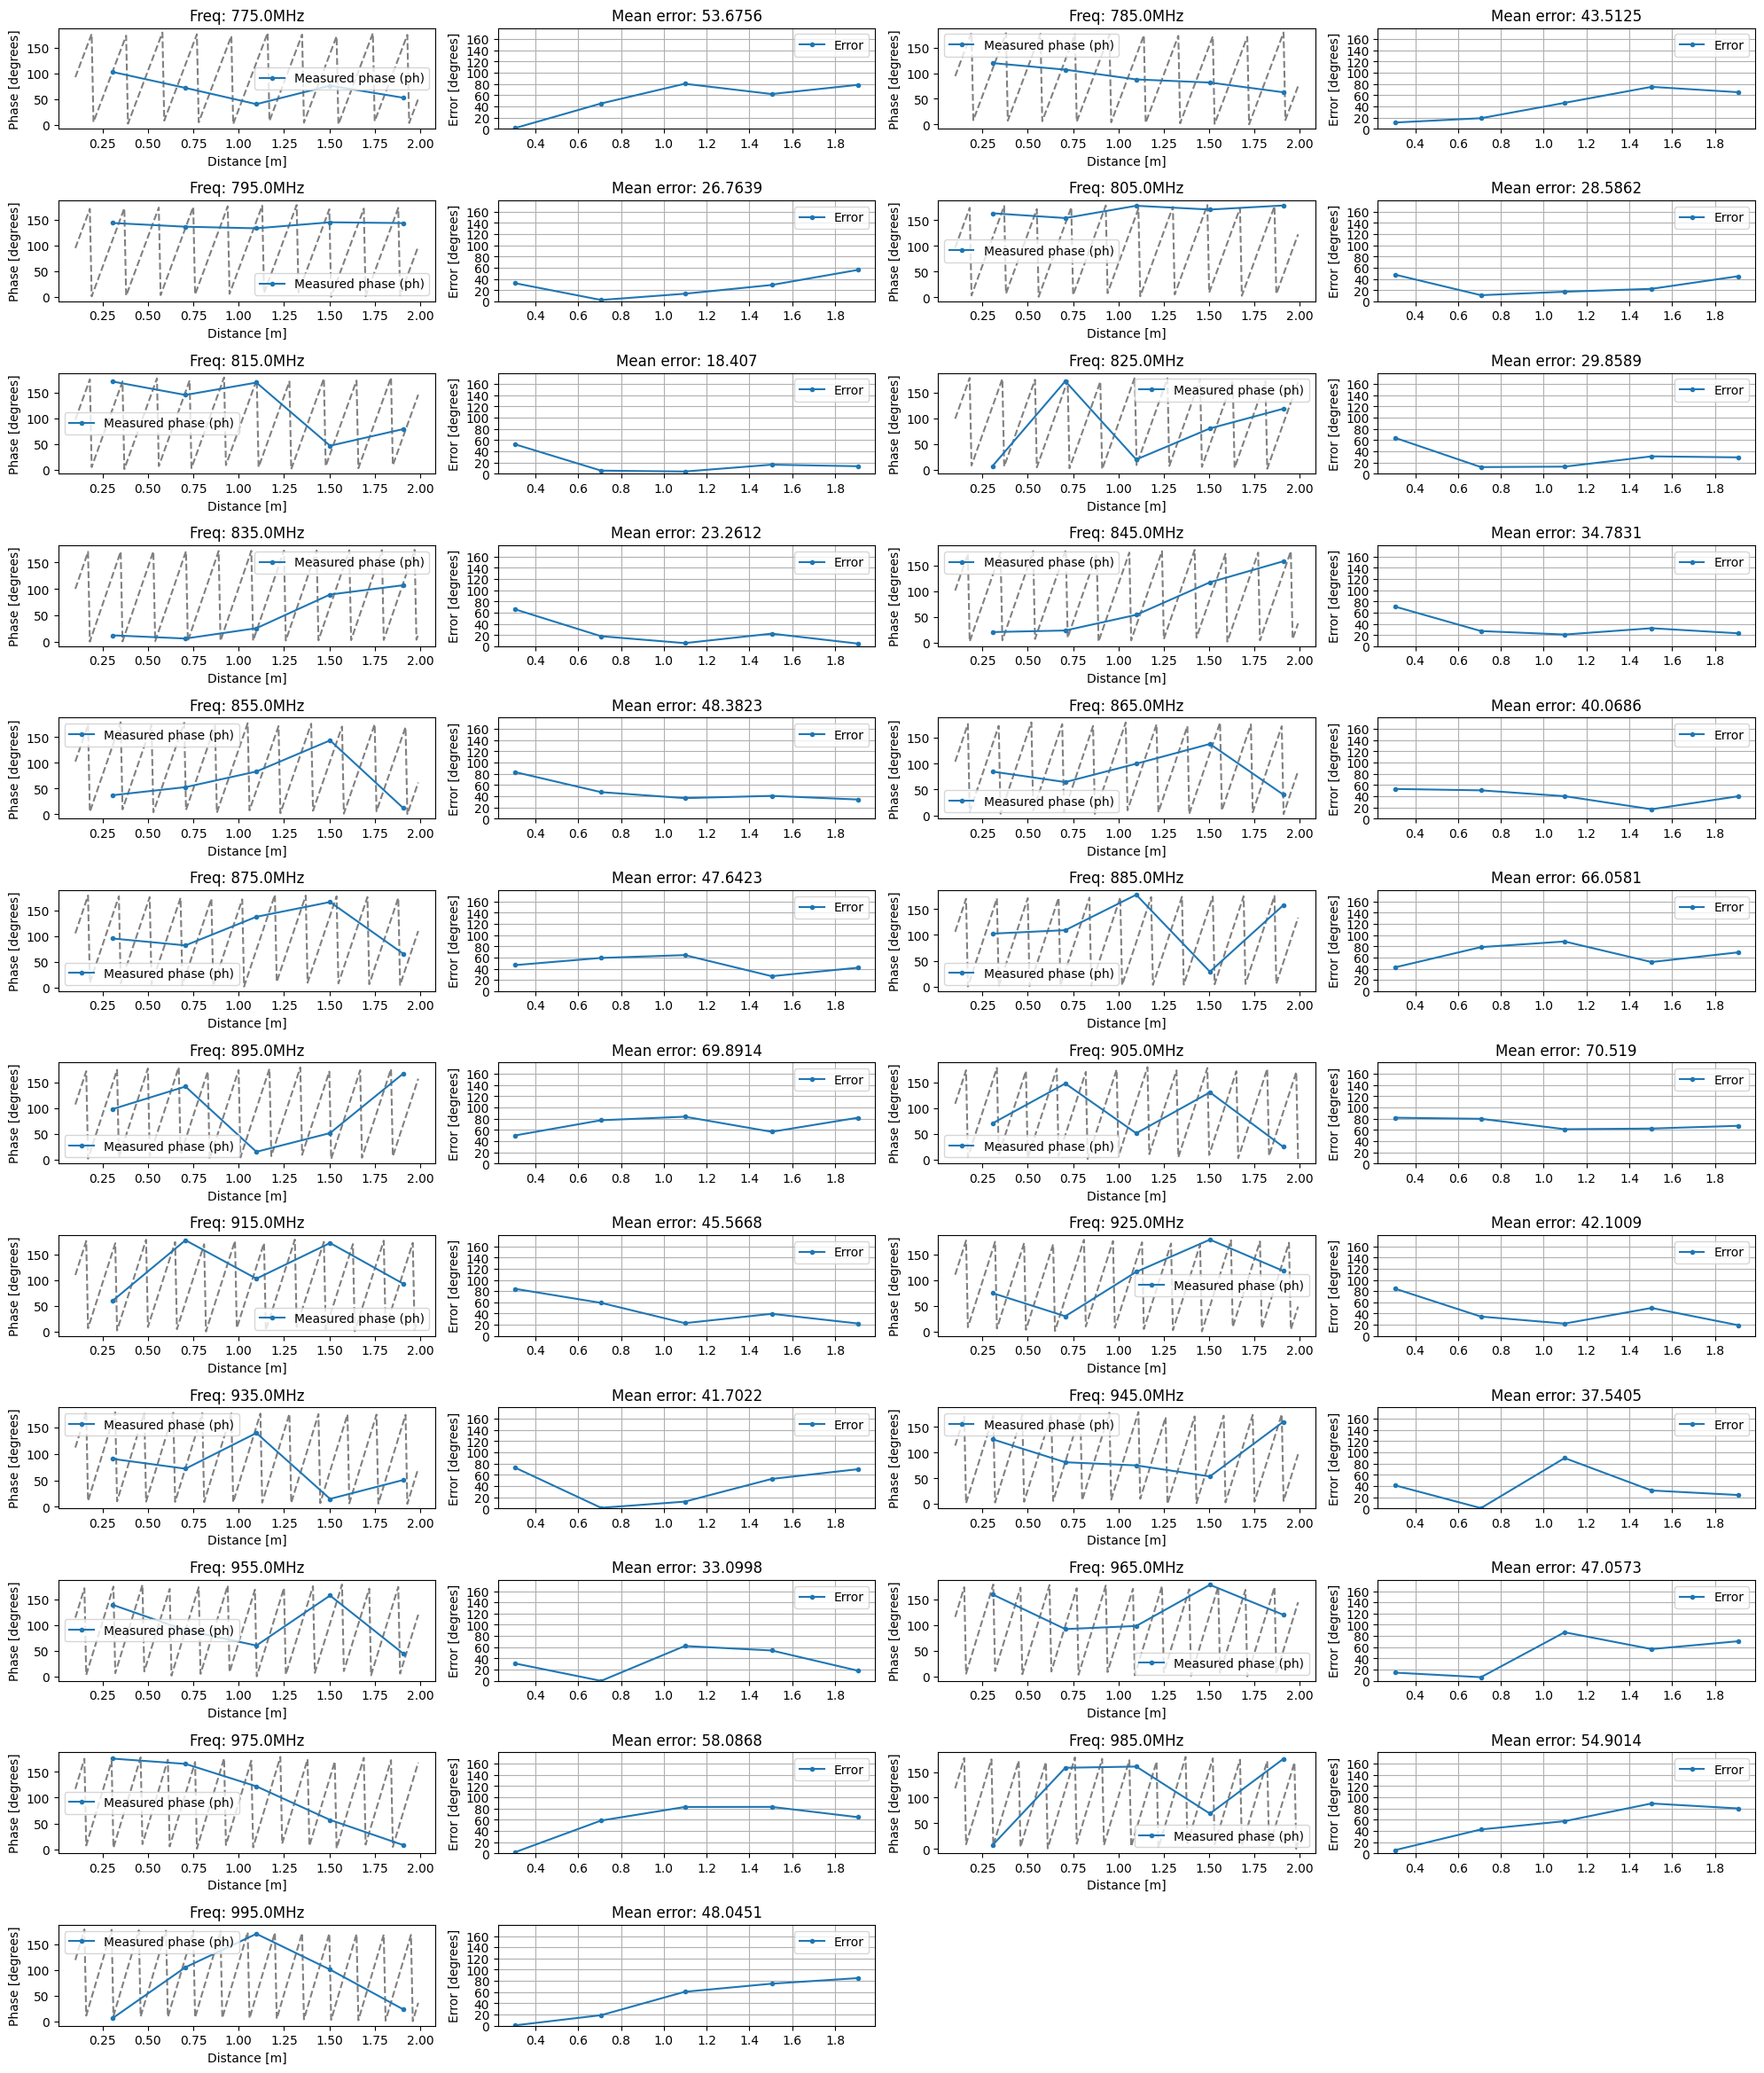

In [22]:
freq_range=np.array(range(775,1000,10))*1e6
all_freqs, all_freqs_unwrapped, all_freqs_theoretical, all_freqs_theoretical_unwrapped, all_errors, \
    selected_experiments_all = multidist_multifreq_phase_estimation(freq_range,processedDF_aggregated,correction_factor=0,plot=True)

with open("no_correction_all_errs.pkl",'wb') as f:
    pickle.dump(all_errors,f)
    
with open("no_correction_all_phases.pkl",'wb') as f:
    pickle.dump(all_freqs,f)

with open("no_correction_all_phases_unwrapped.pkl",'wb') as f:
    pickle.dump(all_freqs_unwrapped,f)    

with open("theoretical_phase.pkl",'wb') as f:
    pickle.dump(all_freqs_theoretical,f)    

### With offset correction using the ground truth.

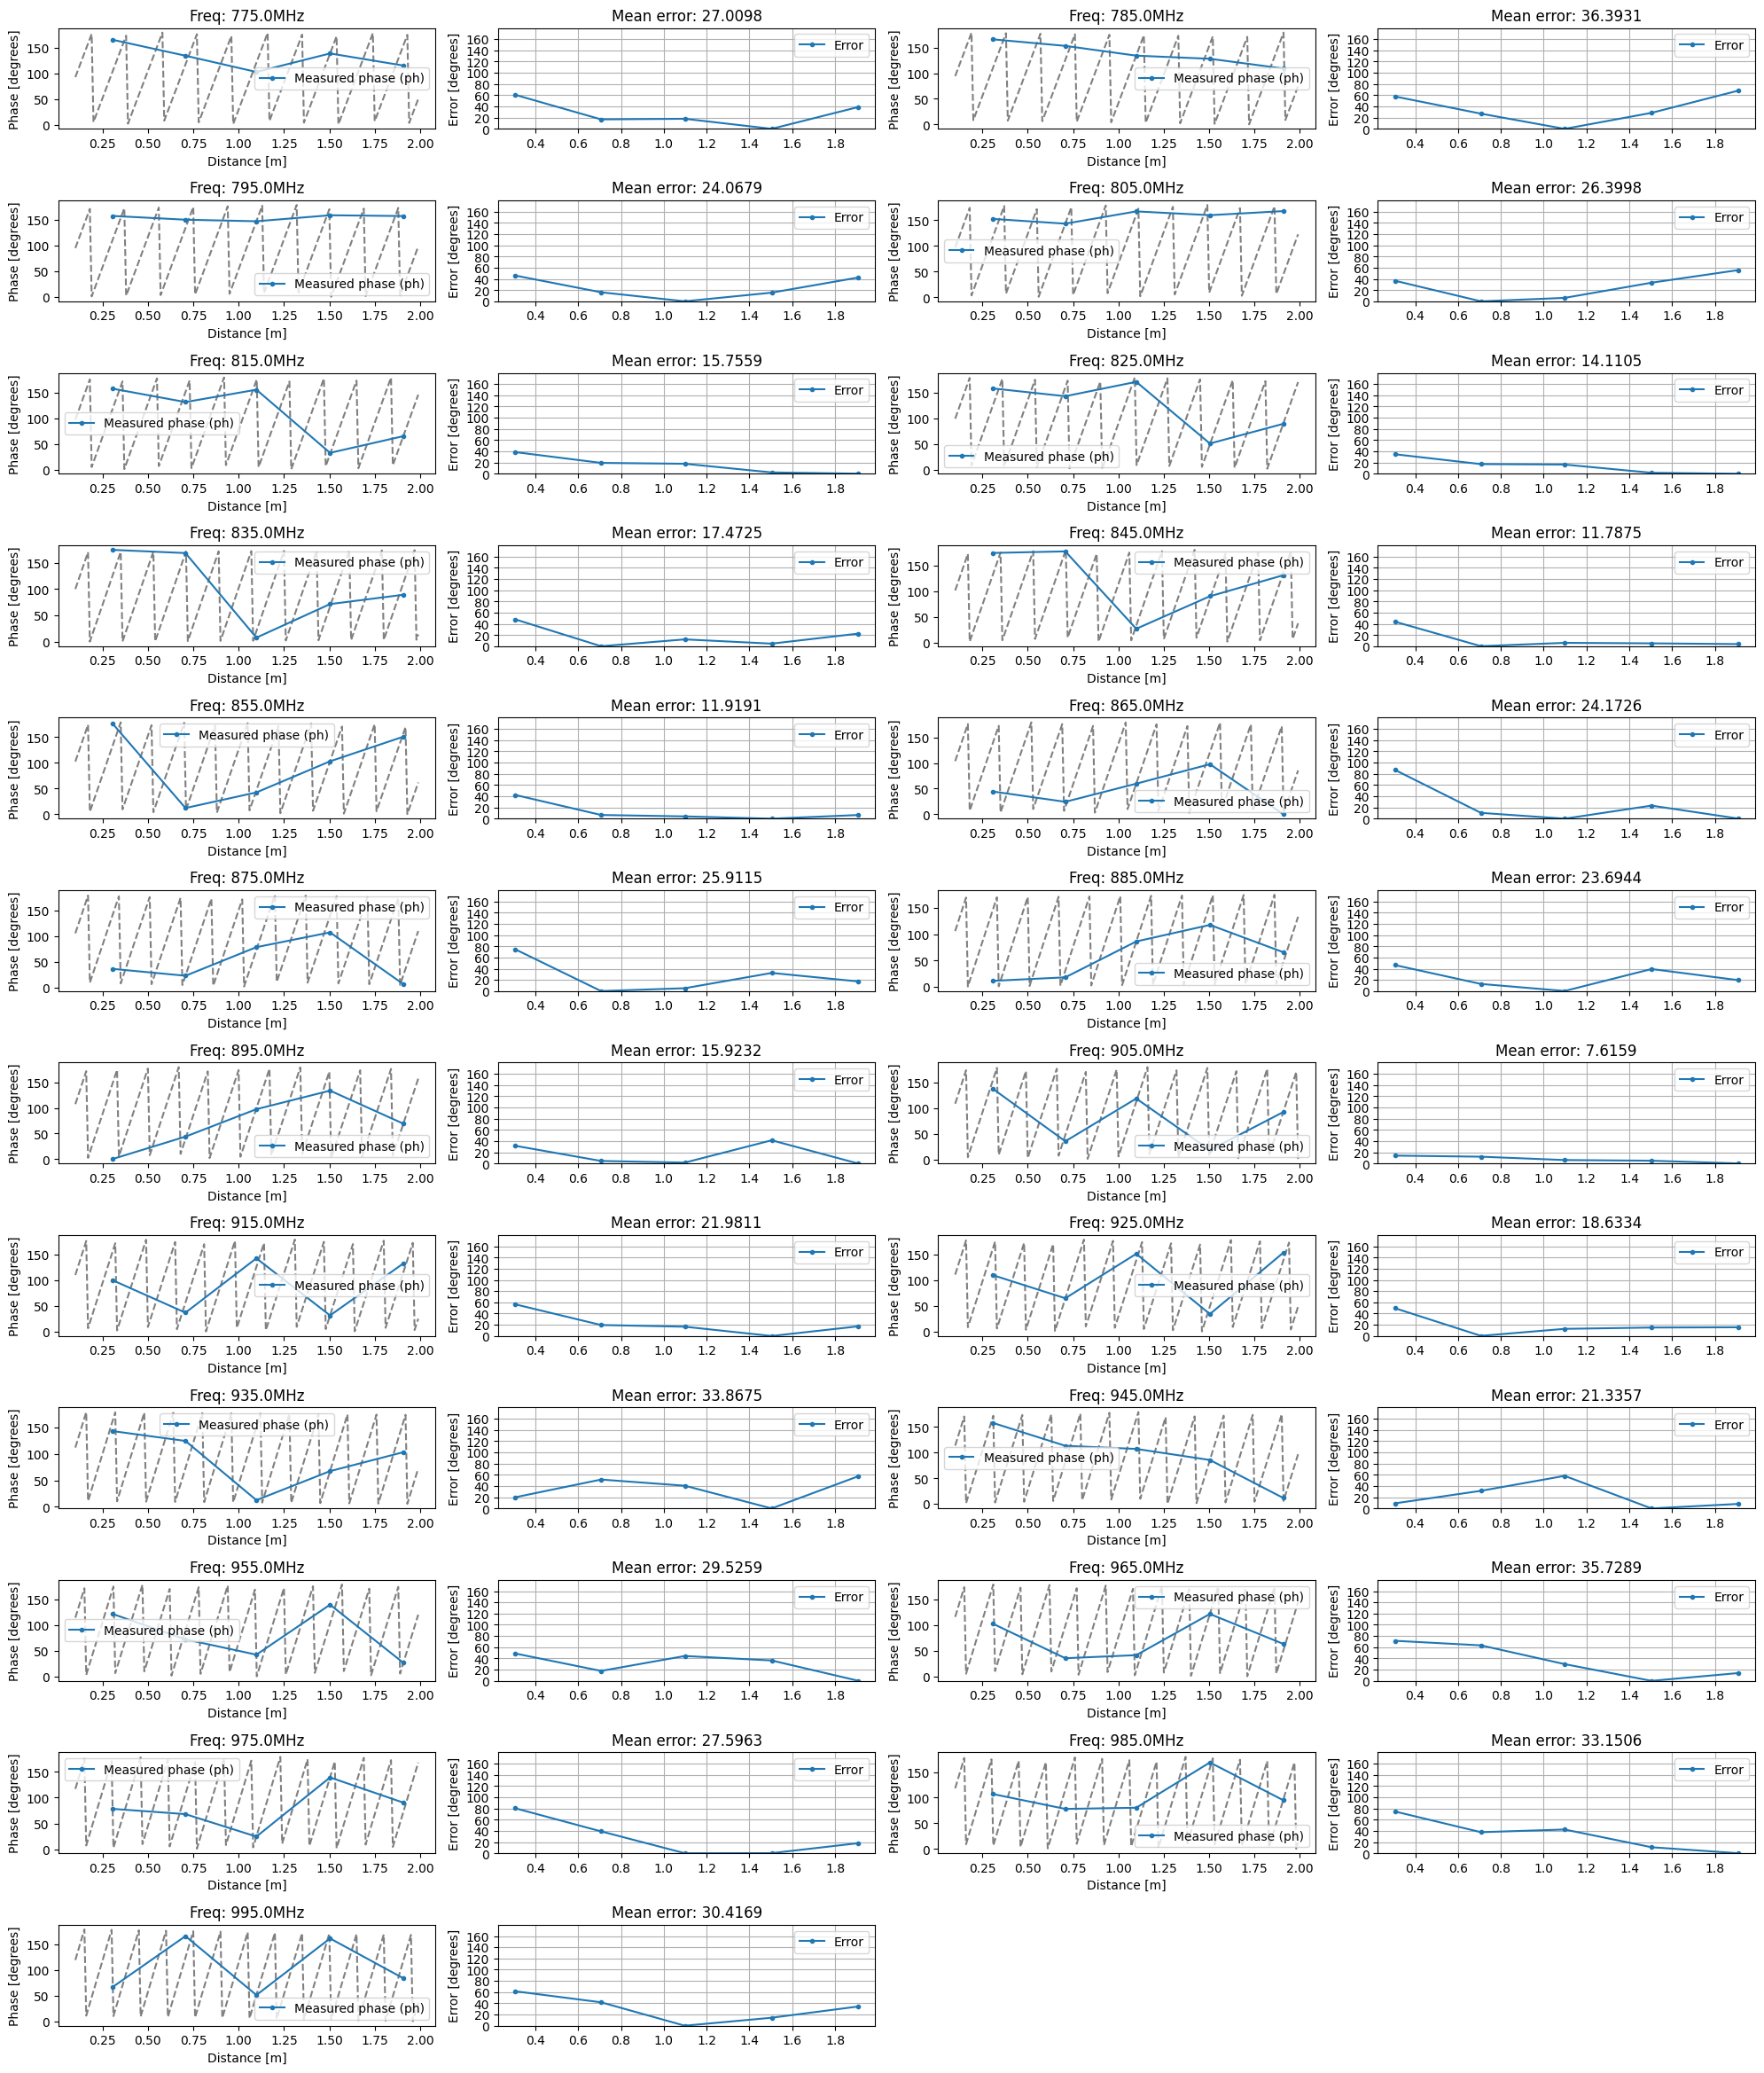

In [23]:
correction_offsets={}
all_errors=None


all_freqs, all_freqs_unwrapped, all_freqs_theoretical, all_freqs_theoretical_unwrapped, _,_=\
    multidist_multifreq_phase_estimation(freq_range,processedDF_aggregated,correction_factor=0,plot=False)


for freq in freq_range:
    offset,best_error,errors=get_offset(all_freqs[freq],freq)
    # print(f"Freq {freq//1e6};\t Mean:{np.mean(errors)};\t Median:{np.median(errors)};\t Std:{np.std(errors)}")
    # if all_errors is None:
    #     all_errors=errors
    # else:
    #     all_errors=np.concat((all_errors,errors))
    correction_offsets[freq]=offset



all_freqs, all_freqs_unwrapped, all_freqs_theoretical, all_freqs_theoretical_unwrapped, all_errors,_=\
    multidist_multifreq_phase_estimation(freq_range,processedDF_aggregated,correction_factor=correction_offsets,plot=True)


with open("gt_correction_all_errs.pkl",'wb') as f:
    pickle.dump(all_errors,f)
    
with open("gt_correction_all_phases.pkl",'wb') as f:
    pickle.dump(all_freqs,f)

with open("gt_correction_all_phases_unwrapped.pkl",'wb') as f:
    pickle.dump(all_freqs_unwrapped,f)    

### With correction offsets from pretrained

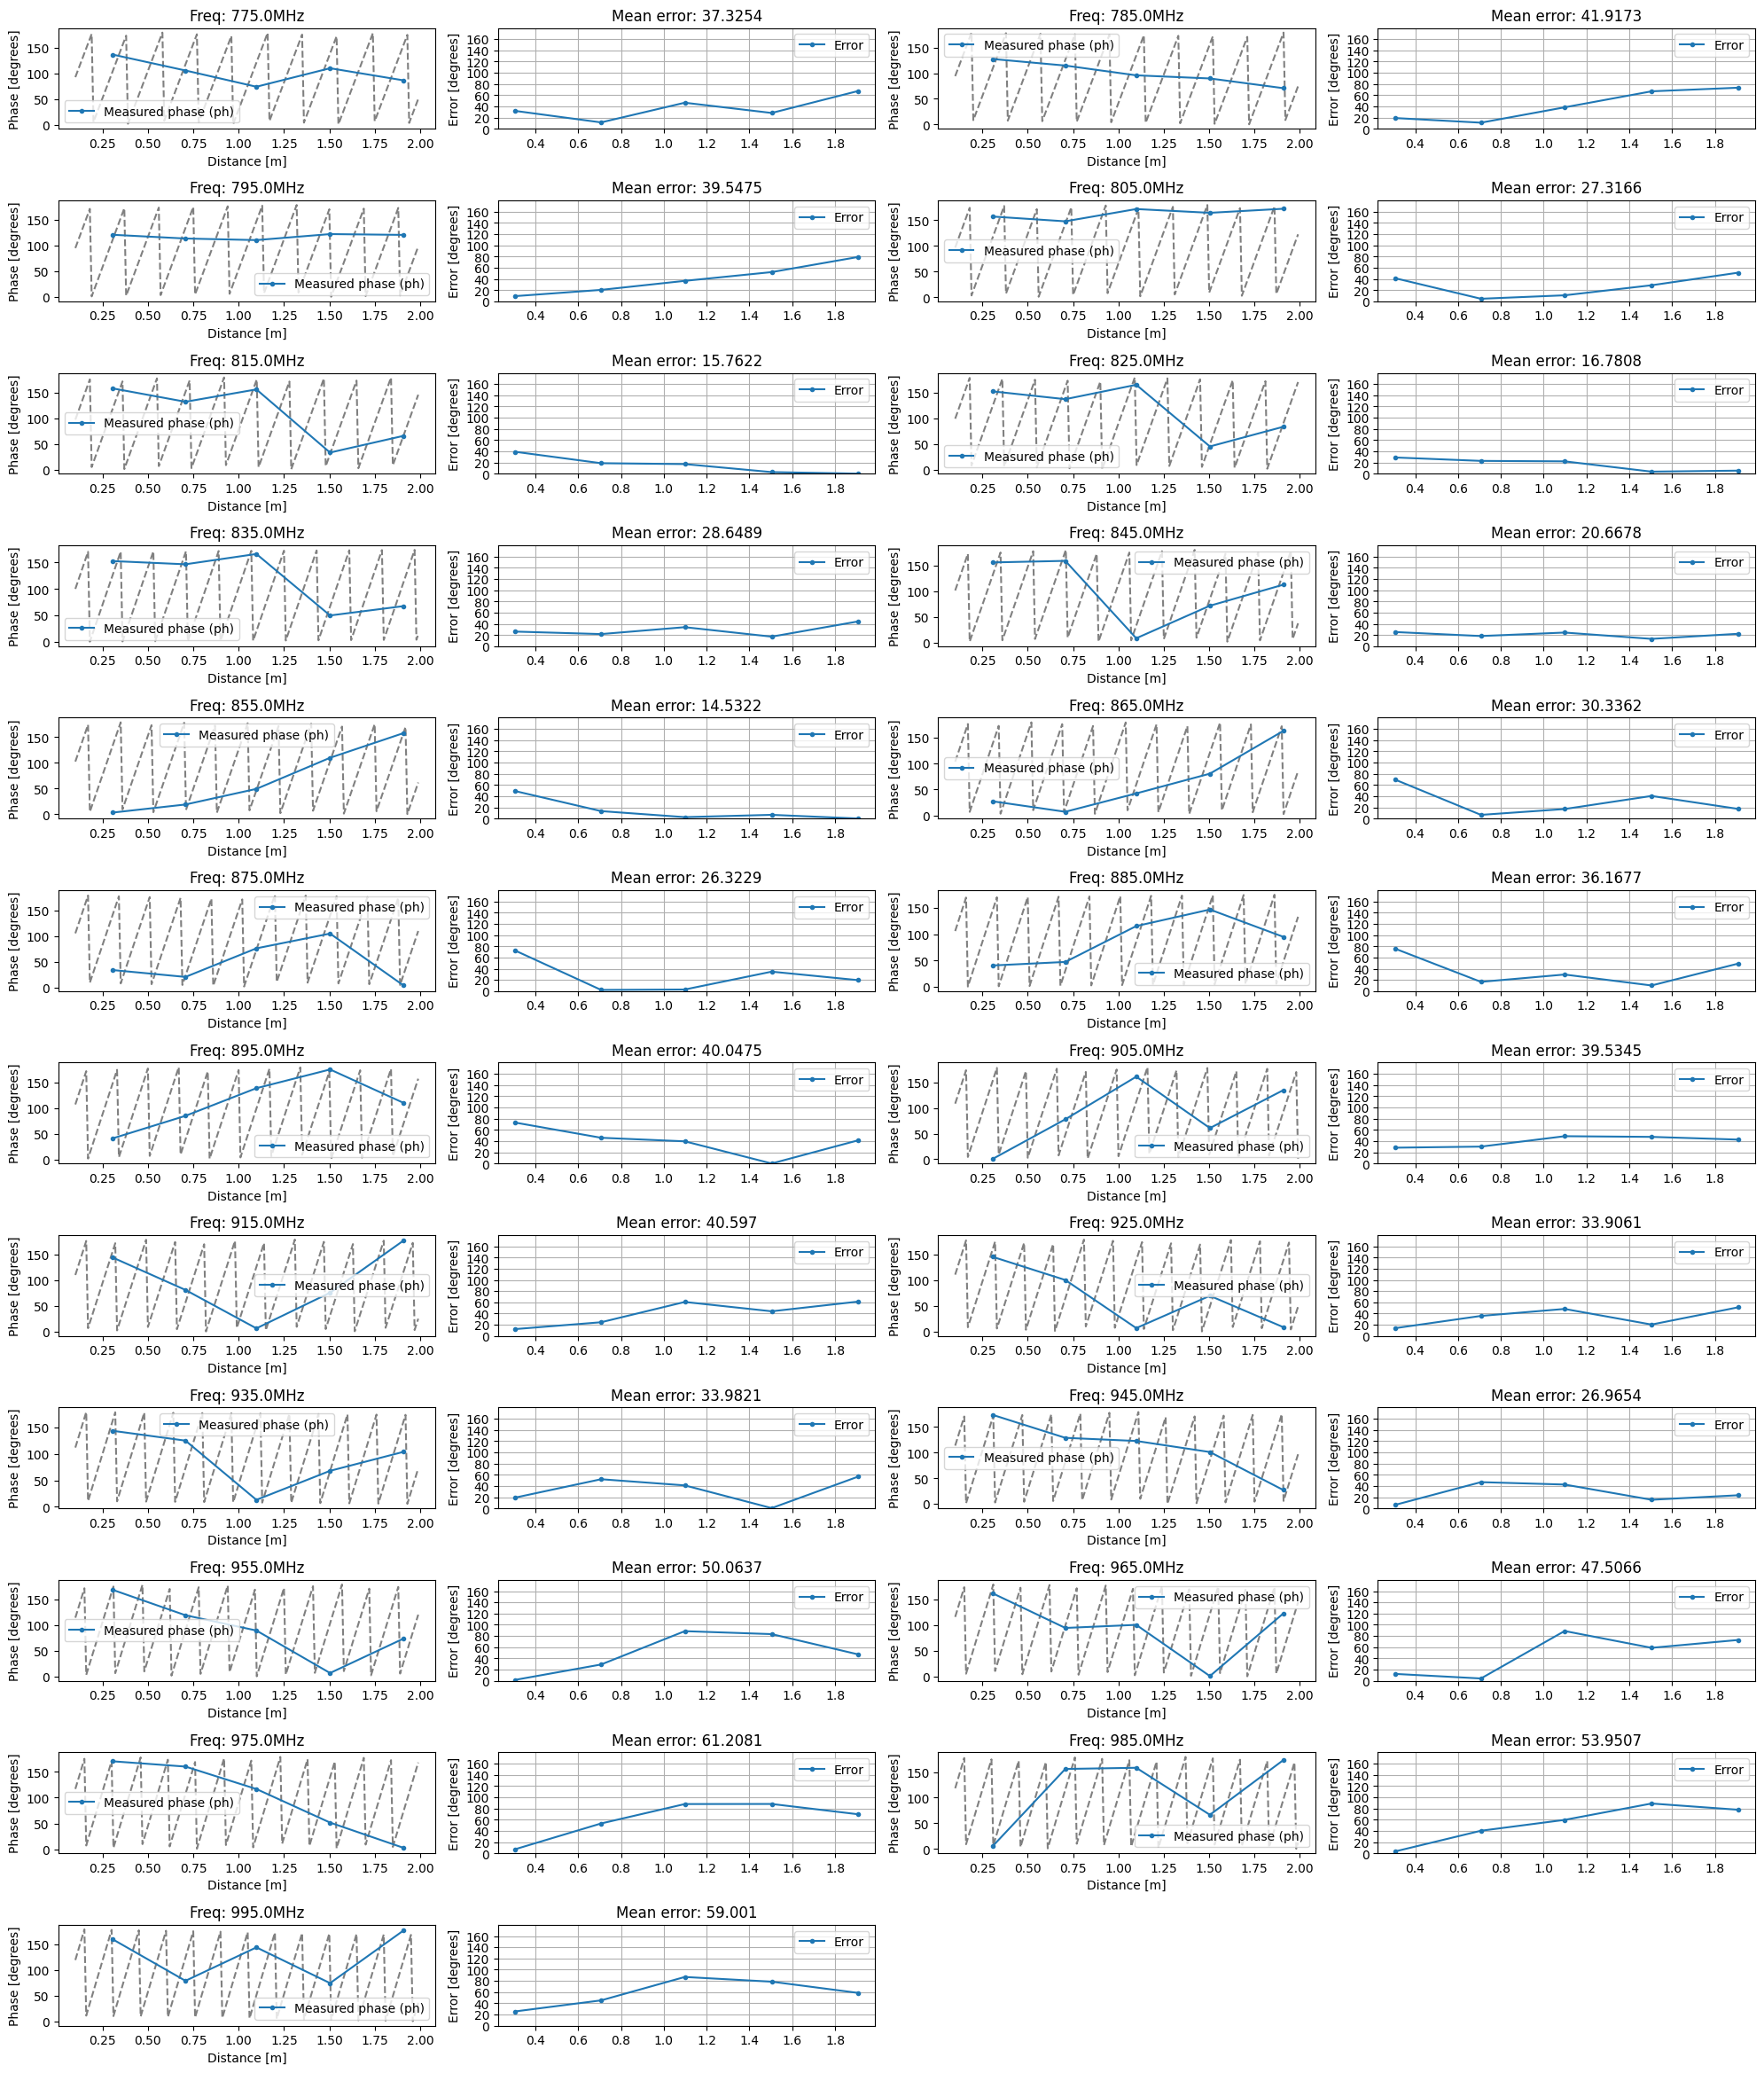

In [24]:
correction_offsets=pickle.load(open("/Users/manavjeet/git/T2TExperiments/DistExperiments/correction_offsets.pkl",'rb'))

all_freqs, all_freqs_unwrapped, all_freqs_theoretical, all_freqs_theoretical_unwrapped, all_errors,_=\
    multidist_multifreq_phase_estimation(freq_range,processedDF_aggregated,correction_factor=correction_offsets,plot=True)


with open("pretrained_correction_all_errs.pkl",'wb') as f:
    pickle.dump(all_errors,f)
    
with open("pretrained_correction_all_phases.pkl",'wb') as f:
    pickle.dump(all_freqs,f)

with open("pretrained_correction_all_phases_unwrapped.pkl",'wb') as f:
    pickle.dump(all_freqs_unwrapped,f)